# Reading SETI Hackathon Data

This tutorial will show you how to programmatically download the SETI code challenge data to your local file space and 
start to analyze it.

Please see the [Step_1_Get_Data.ipynb](Step_1_Get_Data.ipynb) notebook on information about all of the data available for this code challenge. 

This tutorial will use the `basic` data set, but will work, of course, with any of the data sets.

In [1]:
#The ibmseti package contains some useful tools to faciliate reading the data.

#Unfortunately, you must be using Python 2.7. The `ibmset` package does not yet work on Python 3.

#uncomment the line below to install the package
#!pip install --user --upgrade ibmseti

#If running on DSX, YOU WILL NEED TO RESTART YOUR DSX SPARK KERNEL. Click Kernel -> Restart above!

### No Spark Here

You'll notice that this tutorial doesn't use parallelization with Spark. This is to keep this simple and make this code generalizable to folks that are running this analysis on their local machines. 

In [ ]:
import ibmseti
import os

In [ ]:
import zipfile

### Assume you have the data in a local folder

In [21]:
!ls my_data_folder/basic4

basic4.zip


In [ ]:
zz = zipfile.ZipFile(mydatafolder + '/' + 'basic4.zip')

In [ ]:
basic4list = zz.namelist()

In [24]:
firstfile = basic4list[0]
print firstfile

000919a5-bc7f-471e-959c-81adba0b1f36.dat


# Use `ibmseti` for convenience

While it's somewhat trivial to read these data, the `ibmseti.compamp.SimCompamp` class will extract the JSON header and the complex-value time-series data for you.

In [ ]:
import ibmseti
aca = ibmseti.compamp.SimCompamp(zz.open(firstfile).read())

In [27]:
# This data file is classified as a 'squiggle'

aca.header()

{u'signal_classification': u'squiggle',
 u'uuid': u'000919a5-bc7f-471e-959c-81adba0b1f36'}

## The Goal

The goal is to take each simulation data file and 
1. convert the time-series data into a 2D spectrogram
2. Use the 2D spectrogram as an image to train an image classification model

There are multiple ways to improve your model's ability to classify signals. You can
* Modify the time-series data with some signals processing to make a better 2D spectrogram
* Build a really good image classification system
* Try something entirely different, such as 
    * transforming the time-series data in different ways (KTL transform)?
    * use the time-series data directly in model
    
Here we just show how to view the data as a spectrogram

### 1. Converting the time-series data into a spectrogram with `ibmseti`


In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [42]:
## ibmseti.compamp.SimCompamp has a method to calculate the spectrogram for you (without any signal processing applied to the time-series data)

spectrogram = aca.get_spectrogram()

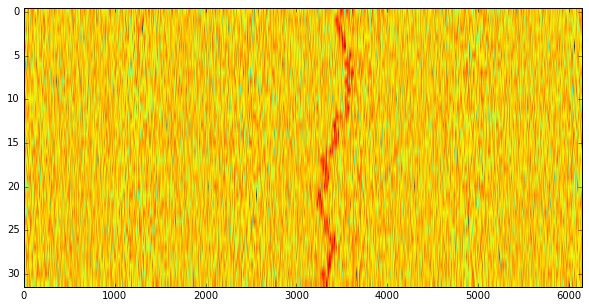

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram),  aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])

### 2. Build the spectogram yourself

You don't need to use `ibmseti` python package to calculate the spectrogram for you. 

This is especially important if you want to apply some signals processing to the time-series data before you create your spectrogram

In [44]:
complex_data = aca.complex_data()

In [45]:
#complex valued time-series

complex_data

array([-12.+19.j, -34. -4.j, -13. -8.j, ...,  11. +4.j,   2.+14.j,
        16. -8.j], dtype=complex64)

In [46]:
complex_data = complex_data.reshape(32, 6144)

In [47]:
complex_data

array([[-12.+19.j, -34. -4.j, -13. -8.j, ...,   1. +1.j,  -4.+17.j,
         11.-13.j],
       [ -4. +7.j,   1.+43.j,  13. +4.j, ..., -21.-18.j,  -2. +2.j,
         -9. +5.j],
       [ -5.-10.j,   4. +2.j, -16. -8.j, ...,  16. -1.j,   1.+24.j,
         -9. +7.j],
       ..., 
       [-14. -7.j,  -4.+10.j,  23.+13.j, ..., -20. +1.j, -15. -9.j,
         -2. -6.j],
       [  3. -2.j, -12. -6.j,  -3.-14.j, ...,   5.-10.j,   7.-35.j,
          9.-17.j],
       [  1. -8.j,  27.-19.j,  -3.+13.j, ...,  11. +4.j,   2.+14.j,
         16. -8.j]], dtype=complex64)

In [48]:
#Apply a Hanning Window

complex_data = complex_data * np.hanning(complex_data.shape[1])

In [49]:
complex_data

array([[ -0.00000000e+00 +0.00000000e+00j,
         -8.89237141e-06 -1.04616134e-06j,
         -1.36000939e-05 -8.36928855e-06j, ...,
          1.04616107e-06 +1.04616107e-06j,
         -1.04616134e-06 +4.44618571e-06j,
          0.00000000e+00 +0.00000000e+00j],
       [ -0.00000000e+00 +0.00000000e+00j,
          2.61540336e-07 +1.12462344e-05j,
          1.36000939e-05 +4.18464428e-06j, ...,
         -2.19693825e-05 -1.88308992e-05j,
         -5.23080671e-07 +5.23080671e-07j,
         -0.00000000e+00 +0.00000000e+00j],
       [  0.00000000e+00 -0.00000000e+00j,
          1.04616134e-06 +5.23080671e-07j,
         -1.67385771e-05 -8.36928855e-06j, ...,
          1.67385771e-05 -1.04616107e-06j,
          2.61540336e-07 +6.27696806e-06j,
         -0.00000000e+00 +0.00000000e+00j],
       ..., 
       [  0.00000000e+00 -0.00000000e+00j,
         -1.04616134e-06 +2.61540336e-06j,
          2.40617046e-05 +1.36000939e-05j, ...,
         -2.09232214e-05 +1.04616107e-06j,
         -3.923105

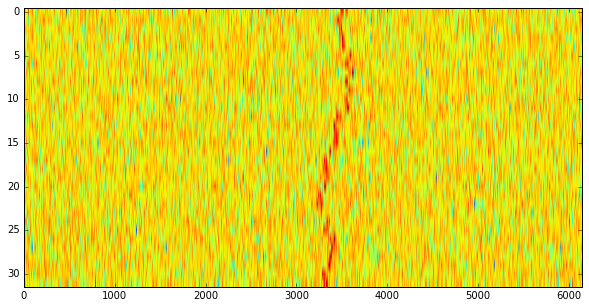

In [50]:
# Build Spectogram & Plot

cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
spectrogram = np.abs(cpfft)**2

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram), aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])


### Hmm, Is this ^ better or worse?

Maybe try a different windowing? Or different method for calculating the spectrogram (see Welch's periodigram? Ask a SETI Researcher?)

### Consider a different "shape" to change the resolution of the frequency bins along the horizontal axis

### Consider different signal processing techniques to improve the signals

### Consider subtracting the noise in Fourier space by modeling the noise with the 'noise' classes

### Ultimately, you'll want to take the full data set, and create a number of PNG files or other image files to feed into an image classifier